# MLP

Pytorch MLP implementation for football match prediction.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.linear import Linear

In [ ]:
import math

In [ ]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print('Device:', device)

Device: cuda


## Model

In [ ]:
num_classes = 3   # number of classes
input_size = 18   # number of features in the input    
hidden_size = 5   # number of features in the hidden state

In [ ]:
class MLP(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size):
        super(MLP, self).__init__()
        self.num_classes = num_classes  # number of classes
        self.input_size = input_size    # input size
        self.hidden_size = hidden_size  # hidden state
        
        self.flatten = nn.Flatten()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),  # fully connected inuput layer
            nn.ReLU(),                           # ReLu
            nn.Linear(hidden_size, hidden_size), # fully connected hidden layer
            nn.ReLU(),                           # ReLu
            nn.Linear(hidden_size, hidden_size), # fully connected hidden layer
            nn.ReLU(),                           # ReLu
            nn.Linear(hidden_size, num_classes)  # fully connected output layer
        )

    def forward(self, x):
        x = self.flatten(x)
        out = self.linear_relu_stack(x)
        return out

    def init_linear(self, m):
        if isinstance(m, nn.Linear):
            # kaiming normal initialization
            dim_in = m.weight.shape[1]
            gain = math.sqrt(2.) # ReLu gain
            u = gain/math.sqrt(dim_in)
            m.weight.data.normal_(0.0, math.pow(u,2)).to(device)

In [ ]:
model = MLP(num_classes, input_size, hidden_size)
model.to(device)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=18, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=5, bias=True)
    (5): ReLU()
    (6): Linear(in_features=5, out_features=3, bias=True)
  )
)

## Training

Hyperparameters:

In [ ]:
lr = 0.001            # learning rate
weight_decay = 0.0  # l2 regularization

In [ ]:
epochs = 10001

Loss:

In [ ]:
criterion = nn.CrossEntropyLoss()

Optimizer:

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

Load training data:

In [ ]:
# if using this dataset, please change input_size to 5
# training_data_batches = torch.load('../data/tensors/training_data_batches.pt') # without last games information

In [ ]:
# if using this dataset, please change input_size to 18
training_data_batches = torch.load('../data/tensors/training_data_with_last_games_batches.pt') # with last games information

### Ploting

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_training_validation_loss(training_losses, validation_losses):
    plt.plot(training_losses, color='red', marker='x', label='training loss') 
    plt.plot(validation_losses, color='orange', marker='x', label='validation loss')
    plt.ylabel('Cross Entropy Loss') 
    plt.xlabel('Batch')
    plt.title("Training/Validation Loss")
    plt.ylim([0.8, 1.2])
    plt.legend()
    plt.savefig('../results/mlp/mlp_' + str(weight_decay) + '_' + str(hidden_size)+ '_' + str(lr) + '_train_val.png')
    plt.show() 

In [ ]:
def plot_accuracy(accuracies):
    plt.plot(accuracies, color='blue', marker='x') 
    plt.ylabel('Accuracy') 
    plt.xlabel('Batch')
    plt.title("Training/Validation Loss")
    plt.ylim([0.4, 0.6])
    plt.savefig('../results/mlp/mlp_' + str(weight_decay) + '_' + str(hidden_size)+ '_' + str(lr) + '_accuracy.png')
    plt.show() 

#### Blocked Cross-Validation

In [ ]:
kfolds = 5
batch_size = len(training_data_batches[0][0])
validation_data_percentage = 0.2


Batch: 1
 Epoch: 0, training loss: 1.07
 Epoch: 500, training loss: 0.97
 Epoch: 1000, training loss: 0.97
 Epoch: 1500, training loss: 0.96
 Epoch: 2000, training loss: 0.96
 Epoch: 2500, training loss: 0.96
 Epoch: 3000, training loss: 0.96
 Epoch: 3500, training loss: 0.96
 Epoch: 4000, training loss: 0.96
 Epoch: 4500, training loss: 0.96
 Epoch: 5000, training loss: 0.96
 Epoch: 5500, training loss: 0.96
 Epoch: 6000, training loss: 0.96
 Epoch: 6500, training loss: 0.96
 Epoch: 7000, training loss: 0.96
 Epoch: 7500, training loss: 0.96
 Epoch: 8000, training loss: 0.96
 Epoch: 8500, training loss: 0.96
 Epoch: 9000, training loss: 0.96
 Epoch: 9500, training loss: 0.96
 Epoch: 10000, training loss: 0.96

Batch 1 Accuracy: 0.50, batch validation loss: 1.02

Batch: 2
 Epoch: 0, training loss: 1.02
 Epoch: 500, training loss: 1.00
 Epoch: 1000, training loss: 1.00
 Epoch: 1500, training loss: 1.00
 Epoch: 2000, training loss: 1.00
 Epoch: 2500, training loss: 1.00
 Epoch: 3000, tr

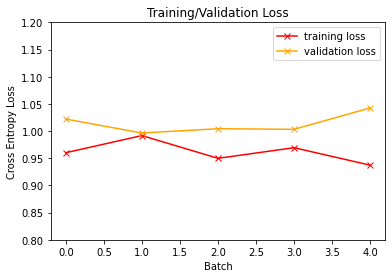

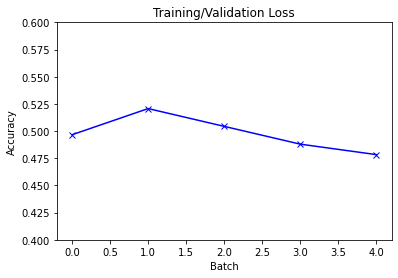

In [ ]:
model.apply(model.init_linear)
training_loss, validation_loss, accuracy = [], [], []  
for k in range(kfolds):
    # Block Cross Validation
    training_data = training_data_batches[0][k]
    labels = training_data_batches[1][k]
    
    # split training/validation data
    training_batch_size = int(training_data.shape[0] * (1.0 - validation_data_percentage))

    training_data_fold = training_data[:training_batch_size, :].to(device)
    validation_data_fold = training_data[training_batch_size:, :].to(device)

    training_labels_fold = labels[:training_batch_size, :].to(device)
    validation_labels_fold = labels[training_batch_size:, :].to(device)

    # training on training dataset
    print("\nBatch: %d" % (k+1))
    model.train()
    for epoch in range(epochs):
        model.zero_grad()
        output = model(training_data_fold)
        loss = criterion(output, training_labels_fold)
        loss.backward()
        optimizer.step()
  
        if epoch % 500 == 0:
            print(" Epoch: %d, training loss: %1.2f" % (epoch, loss.item()))
        
    training_loss.append(loss.item())

    # validation on training dataset
    validation_batch_size = validation_data_fold.shape[0]
    model.eval()
    validation_loss_batch, accuracy_batch = 0.0, 0.0
    with torch.no_grad():
        prediction = model(validation_data_fold)
        validation_loss_batch = criterion(prediction, validation_labels_fold).item()
        accuracy_batch = ((torch.argmax(prediction, dim=1) == torch.argmax(validation_labels_fold, dim=1)).type(torch.float).sum()) / validation_batch_size
    print("\nBatch %d Accuracy: %1.2f, batch validation loss: %1.2f" % (k+1, accuracy_batch, validation_loss_batch))

    validation_loss.append(validation_loss_batch)
    accuracy.append(accuracy_batch.cpu())
training_loss_avg = sum(training_loss) / kfolds
validation_loss_avg = sum(validation_loss) / kfolds
accuracy_avg = sum(accuracy) / kfolds
print("\nAccuracy: %1.2f, trainig loss: %1.2f, validation loss: %1.2f" % (accuracy_avg, training_loss_avg, validation_loss_avg))
plot_training_validation_loss(training_loss, validation_loss)
plot_accuracy(accuracy)